# RGB Image to Uncertainty Score
## 1. Extract Images

In [1]:
import shutil
shutil.unpack_archive('../input/dicom-files-to-rgb-mag-edge1-edge2-512x512/SIIM-FISABIO-RSNA-JPEG.zip', './')

## 2. Plot an example image

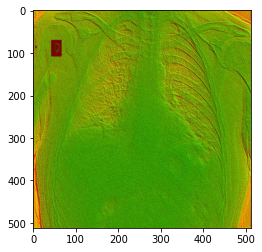

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open("./test/opacity/c52e0c1fca7c.jpeg") 
plt.imshow(img); 
plt.show()

## 3. Loading Model

In [3]:
import torchvision.transforms as T
from torchvision import models
import torch
import torch.nn as nn

trf = T.Compose([T.Resize(448),
                 #T.CenterCrop(448),
                 T.ToTensor(),
                 T.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
                 ])

class NullNet(nn.Module): 
    def __init__(self):
        super(NullNet, self).__init__()
    def forward(self, x):
        return x
    

inp = trf(img).unsqueeze(0)    
model_ft = models.wide_resnet101_2(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = NullNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)


Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

## 4. Obtaining Features

In [4]:
# Pass the input through the net
inp = inp.to(device)
features = model_ft(inp)

print ("Input Shape:",inp.shape)
print ("Feature Shape:",features.shape)

Input Shape: torch.Size([1, 3, 448, 448])
Feature Shape: torch.Size([1, 2048])


## 5. Loading previously trained FC layer

In [5]:
import sys
import torch.nn as nn
PATH = '../input/fork-of-siim-fisabio-rsna-classification-tl/best_model_fc.pt'

model_fc = nn.Linear(num_ftrs, 2)
model_fc = model_fc.to(device)
model_fc.load_state_dict(torch.load(PATH, map_location=device))


print(model_fc)


Linear(in_features=2048, out_features=2, bias=True)


## 6. Computing posteriors from features

In [6]:
out_posterior = model_fc(features)
print(out_posterior)
print(device)

tensor([[-1.1378,  0.9506]], grad_fn=<AddmmBackward>)
cpu


## 7. Loading score computation NN

In [7]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x
    
    
model_S = Net(n_feature=2, n_hidden=500, n_output=1)     # define the network

PATH = '../input/training-nn-for-score/best_model_S.pt'


model_S.load_state_dict(torch.load(PATH, map_location=device))


print(model_S)

Net(
  (hidden): Linear(in_features=2, out_features=500, bias=True)
  (hidden2): Linear(in_features=500, out_features=500, bias=True)
  (predict): Linear(in_features=500, out_features=1, bias=True)
)


## 8. Score computation

In [8]:
import torch.nn.functional as F
import pickle

device = torch.device('cpu')


model_S = model_S.to(device)

# Getting back the objects:
with open('../input/training-nn-for-score/Ranges.pkl','rb') as f:  # Python 3: open(..., 'rb')
    min_x, min_y, max_x, max_y, range_x, range_y = pickle.load(f)

    
    
range_x = max_x - min_x
print('Ranges:', max_x, min_x, range_x)    
out_posterior_n = (out_posterior - min_x)/range_x
print(out_posterior_n)
out_posterior_n = out_posterior_n.to(device)
score = model_S(out_posterior_n)
print('Score:',score)

Ranges: tensor([1.6996, 1.2725]) tensor([-1.3708, -1.7394]) tensor([3.0704, 3.0119])
tensor([[0.0759, 0.8931]], grad_fn=<DivBackward0>)
Score: tensor([[0.9253]], grad_fn=<AddmmBackward>)
